In [ ]:
import pandas as pd
import numpy as np
import warnings
import torch
from torch import autograd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

warnings.filterwarnings('ignore')

#Задание 1 (pandas)

Для выполнения заданий возьмите данные из папки [data](https://drive.google.com/drive/folders/17E4vB5kWr5FNjLKRU4XGoJSVTxn1jkg4?usp=sharing) о продажах. Данные распределены по 4 файлам:
* sales_train.csv - данные о продажах с января 2013 по октябрь 2015.
** date - дата продажы
** date_block_num - номер месяца по порядку следования
** shop_id - идентификатор магазина
** item_id - идентификатор товара
** item_price - цена товара
** item_cnt_day - количество проданного товара одного вида в день

* items.csv - подробная информация о товарах
** item_id - идентификатор товара
** item_name - название товара
** category_id - идентификатор категории товара

* item_categories.csv - подробная информация о категориях товаров
** item_category_id - идентификатор категории товара
** category_name - название категории товара

* shops.csv - подробная информация о магазинах
** shop_id - идентификатор магазина
** shop_name - название магазина


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1XNbvt_Sqf8RVuCJEi4taWU7pPjYheppt"})
downloaded.GetContentFile('item_categories.csv')
downloaded = drive.CreateFile({'id':"1ovTp6MMef5oHs8kPQ-k5tsq1QHsGfcso"})
downloaded.GetContentFile('items.csv')
downloaded = drive.CreateFile({'id':"1shLPYMyXRbDmRn_btXoNptcQkWMhS6Af"})
downloaded.GetContentFile('sales_train.csv')
downloaded = drive.CreateFile({'id':"1hgJ2oKouYHenN-SpU-dUZH7QKaJHBEop"})
downloaded.GetContentFile('shops.csv')

In [ ]:
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
sales_train = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')

## Задание 1.1

1. Найдите топ-10 самых часто покупаемых товаров (не забудьте учесть столбец item_cnt_day).
2. Оставьте только те из них, которые покупали все три года (2013, 2014, 2015).

In [ ]:
res1 = sales_train.groupby('item_id')['item_cnt_day'].agg(sum).reset_index().sort_values(by='item_cnt_day', ascending=False).head(10)
res1 = res1.merge(items)
print('Топ-10 самых часто покупаемых товаров')
res1

Топ-10 самых часто покупаемых товаров


,item_id,item_cnt_day,item_name,category_id
0,20949,187642.0,Corporate package T-shirt 1C Interest white (3...,71
1,2808,17245.0,"Diablo III [PC, Jewel, Russian version]",30
2,3732,16642.0,"Grand Theft Auto V [PS3, Russian subtitles]",19
3,17717,15830.0,Acceptance of funds for 1C-Online,79
4,5822,14515.0,Playstation Store replenishment of wallet: Pay...,35
5,3734,11688.0,"Grand Theft Auto V [Xbox 360, Russian subtitles]",23
6,6675,10289.0,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,12
7,3731,10099.0,"Grand Theft Auto V [PC, Russian subtitles]",30
8,1855,10032.0,"Battlefield 4 [PC, Russian version]",30
9,16787,9227.0,"Some of us [PS3, Russian version]",19


In [ ]:
res1['flag2013'] = res1.apply(lambda x: len(sales_train[(sales_train['item_id'] == x['item_id']) & (sales_train['date_block_num'].between(0, 11, inclusive=True))]) > 0, axis=1)
res1['flag2014'] = res1.apply(lambda x: len(sales_train[(sales_train['item_id'] == x['item_id']) & (sales_train['date_block_num'].between(12, 23, inclusive=True))]) > 0, axis=1)
res1['flag2015'] = res1.apply(lambda x: len(sales_train[(sales_train['item_id'] == x['item_id']) & (sales_train['date_block_num'].between(24, 35, inclusive=True))]) > 0, axis=1)
res1 = res1[(res1['flag2013'] == True) & (res1['flag2014'] == True) & (res1['flag2015'] == True)]
print('Товары, которые покупали все три года')
res1

Товары, которые покупали все три года


,item_id,item_cnt_day,item_name,category_id,flag2013,flag2014,flag2015
0,20949,187642.0,Corporate package T-shirt 1C Interest white (3...,71,True,True,True
1,2808,17245.0,"Diablo III [PC, Jewel, Russian version]",30,True,True,True
2,3732,16642.0,"Grand Theft Auto V [PS3, Russian subtitles]",19,True,True,True
3,17717,15830.0,Acceptance of funds for 1C-Online,79,True,True,True
4,5822,14515.0,Playstation Store replenishment of wallet: Pay...,35,True,True,True
5,3734,11688.0,"Grand Theft Auto V [Xbox 360, Russian subtitles]",23,True,True,True
6,6675,10289.0,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,12,True,True,True
8,1855,10032.0,"Battlefield 4 [PC, Russian version]",30,True,True,True
9,16787,9227.0,"Some of us [PS3, Russian version]",19,True,True,True


## Задание 1.2

1. Определите категорию товаров, в которой совершается минимальное число покупок. Выведите айди и название категории.
2. Определите категорию товаров, в которой совершается максимальное число покупок. Выведите айди и название категории.

*Если таких категорий несколько, выведите все.*

In [ ]:
item_categories = item_categories.rename(columns={"item_category_id": "category_id"})
sales_train = sales_train.merge(items).merge(item_categories).merge(shops)

In [ ]:
sorted = sales_train.groupby('category_id')['item_cnt_day'].agg(sum).sort_values().reset_index()

In [ ]:
print('Категория товаров, в которой совершается минимальное число покупок')
min_category = sorted[sorted['item_cnt_day'] == sorted['item_cnt_day'].min()].merge(item_categories)
min_category

Категория товаров, в которой совершается минимальное число покупок


,category_id,item_cnt_day,item_category_name
0,51,1.0,Books - Cognitive literature
1,10,1.0,Game consoles - PS2


In [ ]:
print('Категория товаров, в которой совершается максимальное число покупок')
max_category = sorted[sorted['item_cnt_day'] == sorted['item_cnt_day'].max()].merge(item_categories)
max_category

Категория товаров, в которой совершается максимальное число покупок


,category_id,item_cnt_day,item_category_name
0,40,634171.0,Cinema - DVD


## Задание 1.3

1. Для категорий из задания 2 найдите среднее количество продаж каждого товара категории в 5 магазинах с наибольшими продажами. Оставьте в таблице только те товары, среднее количество продаж которых строго больше 100.
2. Найдите месяц с максимальными продажами для каждого товара из пункта 1.


In [ ]:
# id магазинов с наибольшими продажами
shop_ids = list(sales_train.groupby('shop_id')['item_cnt_day'].agg(sum).sort_values(ascending=False).head().index)
category_ids = [51, 10, 40]
sales_train_slice = sales_train[sales_train['shop_id'].isin(shop_ids) & sales_train['category_id'].isin(category_ids)]

In [ ]:
avg_sales = sales_train_slice.groupby(['item_id', 'date_block_num'])['item_cnt_day'].agg('sum').sort_values().reset_index()
avg_sales = avg_sales.groupby('item_id')['item_cnt_day'].agg('mean').sort_values().reset_index().merge(items)
max_avg_sales = avg_sales[avg_sales['item_cnt_day'] > 100]
max_avg_sales

,item_id,item_cnt_day,item_name,category_id
4712,16581,101.75,ARGO OPERATION,40
4713,21376,174.00,HOBBIT: AN UNDETALIZED JOURNEY (2DVD),40


In [ ]:
sales_train_slice['date'] =  pd.to_datetime(sales_train_slice['date'], format='%d.%m.%Y')
sales_train_slice['month'] = sales_train_slice['date'].dt.month

In [ ]:
max_avg_sales['max_month'] = max_avg_sales.apply(lambda x: list(sales_train_slice[sales_train_slice['item_id'] == x['item_id']].groupby('month')['item_cnt_day'].agg('sum').sort_values(ascending=False).index)[0], axis=1)
max_avg_sales

,item_id,item_cnt_day,item_name,category_id,max_month
4712,16581,101.75,ARGO OPERATION,40,2
4713,21376,174.00,HOBBIT: AN UNDETALIZED JOURNEY (2DVD),40,4


# Задание 2 (pytorch + matplotlib)

Пусть $f(x) = 3\sin(x) * x$+5. Постройте график $f(x)$ и $\frac{df(x)}{dx}$, для расчета производных воспользуйтесь методом [`backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) и matplotlib для построения графиков. Графики функции и производной разместить на одном изображении.

In [ ]:
x = []
y = []
dy = []
for i in np.arange(-10, 10, 0.1):
  x_i = torch.tensor(float(i), requires_grad=True)
  x.append(x_i.detach().numpy())

  y_i = 3 * x_i * torch.sin(x_i) + 5
  y.append(y_i.detach().numpy())

  y_i.backward()
  dy.append(x_i.grad)

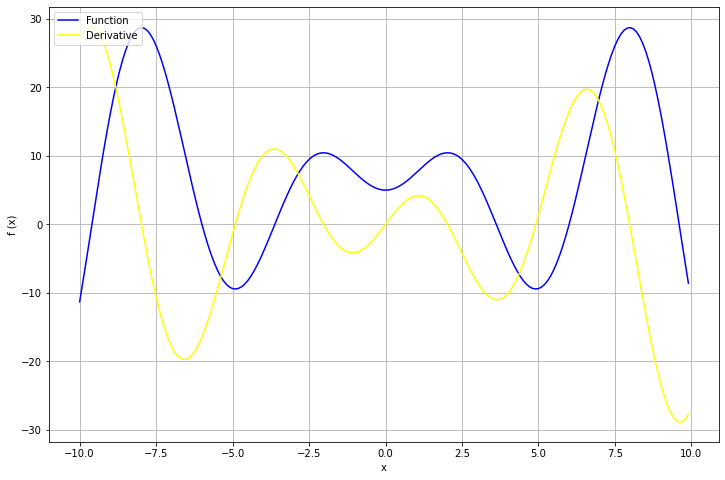

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(x, y, color='blue', label='Function')
plt.plot(x, dy, color='yellow', label='Derivative')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('x')
plt.ylabel('f (x)')
plt.show()
# подписать оси

# Задание 3 (scipy + matplotlib)

Дано две функции:

\begin{matrix} F(x) = a_{11}x^2 + a_{12}x + a_{13}&(1) \\ P(x) = a_{21}x^2+a_{22}x + a_{23} &(2) \end{matrix}
​
* На вход программа должна принимать 2 строки (т.е. должен быть реализован ввод с клавиатуры). Каждая строка содержит 3 действительных числа через пробел: коэффициенты $a$.
* Необходимо найти точки экстремума функций (например, через функцию [`minimize_scalar()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html), [`fmin()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html) и др.) и определить, есть ли у функций общие решения при введенных коэффициентах на некотором диапазоне значений $x$, предусмотрев ситуации, когда решение есть, решений нет и решений бесконечно много. Ответ вывести. В случае, если решения есть (или их бесконечно много), необходимо построить график, на котором построены графики обеих функций, отмечены эти решения и экстремумы функций (другим цветом).


In [ ]:
def ex3(a1, a2):
  def f(x):
    return a1[0] * x * x + a1[1] * x + a1[2]

  def p(x):
    return a2[0] * x * x + a2[1] * x + a2[2]

  ext1 = None
  if a1[0] == 0:
    print('У функции F(x) экстремумов нет')
  elif a1[0] < 0:
    a1 = [-i for i in a1]
    ext1 = round(minimize_scalar(f).x, 3)
    a1 = [-i for i in a1]
    print('Точка максимума F(x), x_max =', ext1)
  else:
    ext1 = round(minimize_scalar(f).x, 3)
    print('Точка минимума F(x), x_min =', ext1)

  ext2 = None
  if a2[0] == 0:
    print('У функции P(x) экстремумов нет')
  elif a2[0] < 0:
    a2 = [-i for i in a2]
    ext2 = round(minimize_scalar(p).x, 3)
    a2 = [-i for i in a2]
    print('Точка максимума P(x), x_max =', ext2)
  else:
    ext2 = round(minimize_scalar(p).x, 3)
    print('Точка минимума P(x), x_min =', ext2)

  flag = False
  x1 = None
  x2 = None
  if (a1[0] == a2[0]) & (a1[1] == a2[1]) & (a1[2] == a2[2]):
    print('Решений бесконечно много')
    flag = True
  else:
    # приравняем правые части функций, получаем уравнение вида a*x^2 + b*x + c = 0
    a = a1[0] - a2[0]
    b = a1[1] - a2[1]
    c = a1[2] - a2[2]
    if a != 0:
      D = b * b - 4 * a * c
      if D > 0:
        flag = True
        # Одна/две точки пересечения
        x1 = (- b + np.sqrt(D))/ (2 * a)
        x2 = (- b - np.sqrt(D))/ (2 * a)
        print('Два решения', x1, x2)
      elif D == 0:
        flag = True
        x1 = -b / (2 * a)
        print('Одно решение', x1)
      else:
        print('Решений нет')
    elif b != 0:
      flag = True
      x1 = - c / b
      print('Одно решение', x1)
    elif c != 0:
      print('Решений нет')

  if flag == True:
    x_vals = []
    f_vals = []
    p_vals = []

    plt_min = -10
    plt_max = 10
    step = 0.1

    if x1 is not None:
      if x2 is not None:
        plt_min = min(x1, x2) - 3
        plt_max = max(x1, x2) + 3
        step = (plt_max - plt_min) / 1000
      else:
        plt_min = x1 - 3
        plt_max = x1 + 3

    for i in np.arange(plt_min, plt_max, step):
      x_vals.append(i)
      f_vals.append(f(i))
      p_vals.append(p(i))

    plt.figure(figsize=(12, 8))
    plt.plot(x_vals, f_vals, color='yellow', label='F(x)')
    plt.plot(x_vals, p_vals, color='blue', label='P(x)')
    if x1 is None and x2 is None:
      plt.text(plt_min,f(plt_min), "Бесконечно много решений")
    if x1 is not None:
      plt.scatter(x1, f(x1), s=50, color='black')
    if x2 is not None:
      plt.scatter(x2, f(x2), s=50, color='black')
    if ext1 is not None:
      plt.scatter(ext1, f(ext1), s=50, color='orange', label='ext_1')
    if ext2 is not None:
      plt.scatter(ext2, p(ext2), s=50, color='cyan', label='ext_2')
    plt.legend(loc='upper left')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.show()

In [ ]:
print('Введите коэффициенты для F(x)')
a1 = input()
a1 = list(map(float, a1.split()))
print(f"F(x) = {a1[0]} * x^2 + {a1[1]} * x + {a1[2]}")
print()

print('Введите коэффициенты для P(x)')
a2 = input()
a2 = list(map(float, a2.split()))
print(f'P(x) = {a2[0]} * x^2 + {a2[1]} * x + {a2[2]}')

ex3(a1, a2)

Введите коэффициенты для F(x)
1 2 3
F(x) = 1.0 * x^2 + 2.0 * x + 3.0

Введите коэффициенты для P(x)
1 2 2
P(x) = 1.0 * x^2 + 2.0 * x + 2.0
Точка минимума F(x), x_min = -1.0
Точка минимума P(x), x_min = -1.0
Решений нет


Пример 1. Две параболы, бесконечно много решений
Точка минимума F(x), x_min = -1.0
Точка минимума P(x), x_min = -1.0
Решений бесконечно много


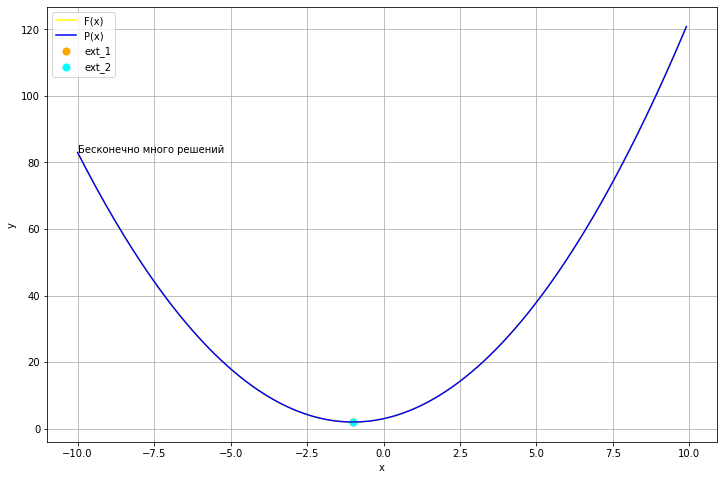

In [ ]:
print('Пример 1. Две параболы, бесконечно много решений')
ex3([1.0, 2.0, 3.0], [1.0, 2.0, 3.0])

Пример 2. Две параболы, два общих решения
Точка минимума F(x), x_min = 0.0
Точка максимума P(x), x_max = 0.0
Два решения 1.0 -1.0


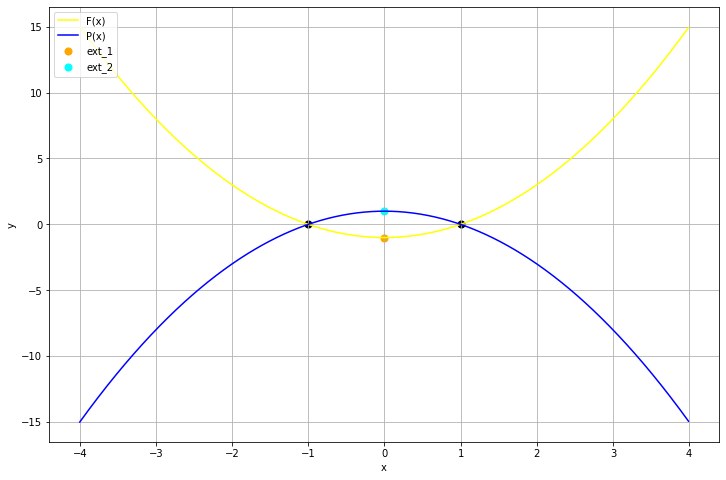

In [ ]:
print('Пример 2. Две параболы, два общих решения')
ex3([1.0, 0.0, -1.0], [-1.0, 0.0, 1.0])

Пример 3. Две параболы, одно общее решениe
Точка минимума F(x), x_min = 0.0
Точка максимума P(x), x_max = 0.0
Одно решение -0.0


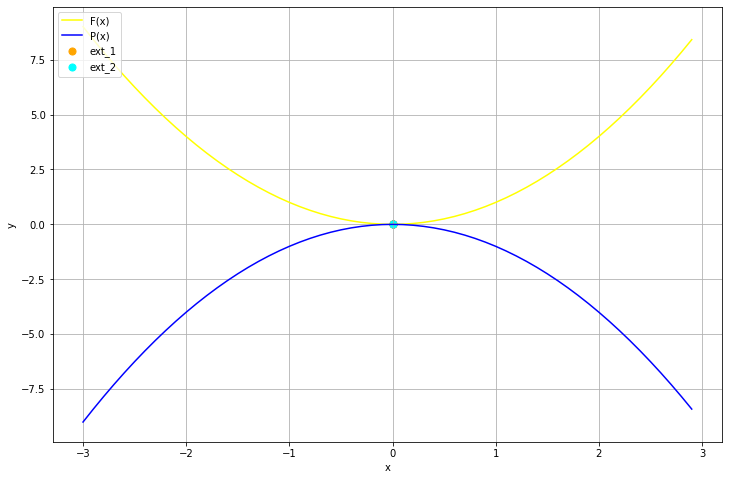

In [ ]:
print('Пример 3. Две параболы, одно общее решениe')
ex3([1.0, 0.0, 0.0], [-1.0, 0.0, 0.0])

In [ ]:
print('Пример 4. Две параболы, общих решений нет')
ex3([1.0, 0.0, 1.0], [-1.0, 0.0, -1.0])

Пример 4. Две параболы, общих решений нет
Точка минимума F(x), x_min = 0.0
Точка максимума P(x), x_max = 0.0
Решений нет


Пример 5. Парабола и прямая, два общих решения
Точка минимума F(x), x_min = 0.0
У функции P(x) экстремумов нет
Два решения 1.7320508075688772 -1.7320508075688772


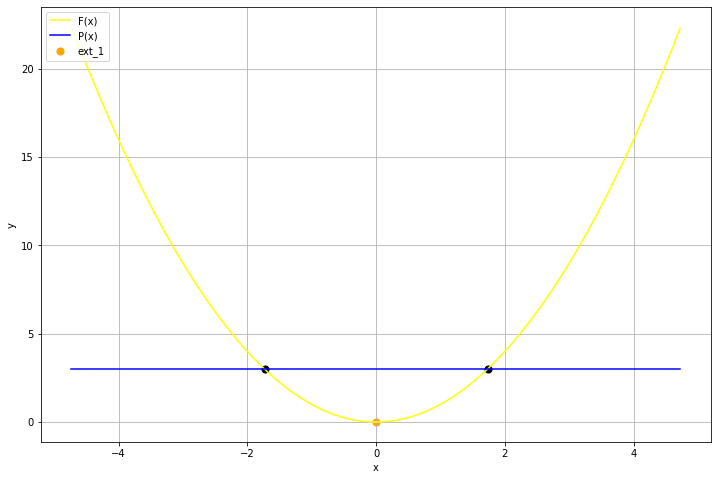

In [ ]:
print('Пример 5. Парабола и прямая, два общих решения')
ex3([1.0, 0.0, 0.0], [0.0, 0.0, 3.0])

Пример 6. Парабола и прямая, одно общее решение
Точка минимума F(x), x_min = 0.0
У функции P(x) экстремумов нет
Одно решение 1.0


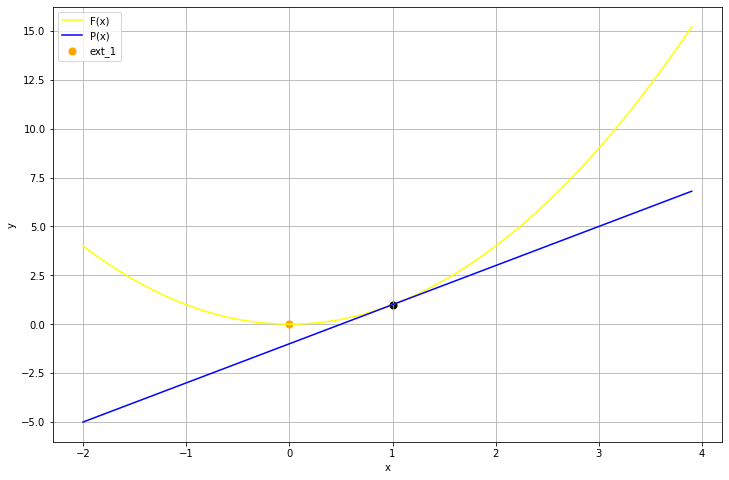

In [ ]:
print('Пример 6. Парабола и прямая, одно общее решение')
ex3([1.0, 0.0, 0.0], [0.0, 2.0, -1.0])

In [ ]:
print('Пример 7. Парабола и прямая, общих решений нет')
ex3([1.0, 0.0, 0.0], [0.0, 0.0, -1.0])

Пример 7. Парабола и прямая, общих решений нет
Точка минимума F(x), x_min = 0.0
У функции P(x) экстремумов нет
Решений нет


Пример 8. Две прямые, бесконечно много решений
У функции F(x) экстремумов нет
У функции P(x) экстремумов нет
Решений бесконечно много


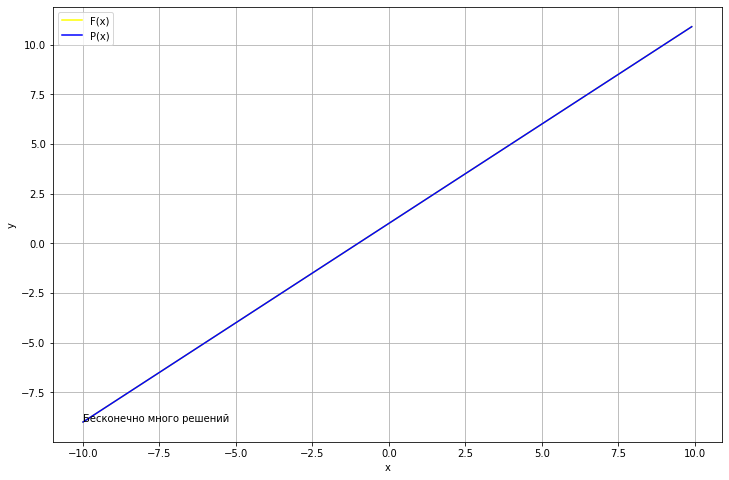

In [ ]:
print('Пример 8. Две прямые, бесконечно много решений')
ex3([0.0, 1.0, 1.0], [0.0, 1.0, 1.0])

Пример 9. Две прямые, одно общее решение
У функции F(x) экстремумов нет
У функции P(x) экстремумов нет
Одно решение 0.5


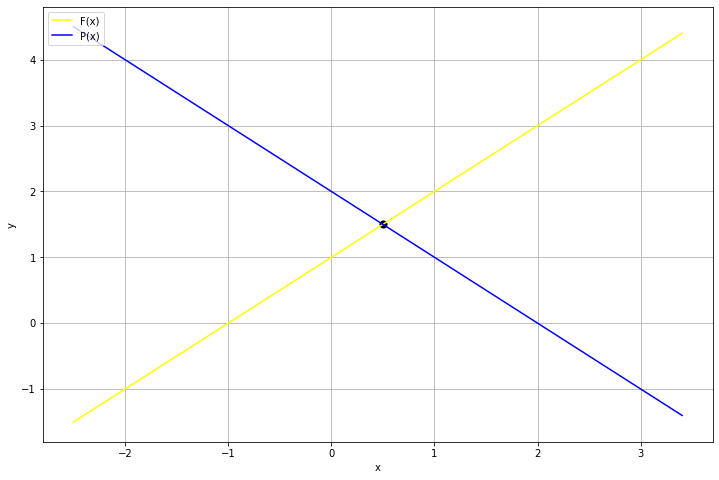

In [ ]:
print('Пример 9. Две прямые, одно общее решение')
ex3([0.0, 1.0, 1.0], [0.0, -1.0, 2.0])

In [ ]:
print('Пример 10. Две прямые, общих решений нет')
ex3([0.0, 1.0, 1.0], [0.0, 1.0, 2.0])

Пример 10. Две прямые, общих решений нет
У функции F(x) экстремумов нет
У функции P(x) экстремумов нет
Решений нет
